In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from collections import Counter
from wordcloud import WordCloud


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [6]:
df = pd.read_csv('/home/ro/PycharmProjects/My/Data setai/kickstarter-projects/ks-projects-201801.csv')

In [7]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [8]:
df.shape

(378661, 15)

In [15]:
df.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

In [23]:
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [26]:
df.dropna(axis = 0, inplace = True)
#axis means that we remowe rows with null values

In [27]:
df.shape

(374860, 15)

In [55]:
#lets check how many projects are successufl

def success_rate (df, state):
    x = pd.concat([df[state].value_counts(normalize = True) * 100,
    #normalize = True --> returns count devided by 374860(vhole df)
                  df[state].value_counts(normalize = False)], axis = 1)
    x = round(x, 2) #round up numbers
    #axis = 1 --> conacatinating columns
    x.columns = ['% of projects', 'count']
    return x

In [56]:
print(success_rate(df, 'state'))

            % of projects   count
failed              52.72  197611
successful          35.71  133851
canceled            10.34   38757
live                 0.75    2798
suspended            0.49    1843


In [60]:
#removing 'canceled', 'live', 'suspended' projects from data Frame
df.query("state in ['failed', 'successful']", inplace = True)

In [61]:
success_rate(df, 'state')

,% of projects,count
failed,59.62,197611
successful,40.38,133851


In [64]:
# select features

df = df.loc[:, ['name', 'category', 'main_category', 'deadline', 
                'usd_goal_real', 'launched', 'state', 'country']]

In [65]:
df.rename(columns={'usd_goal_real' : 'goal'}, inplace = True)

In [73]:
cat_success = success_rate(df, 'main_category')

In [76]:
cat_success.columns

Index(['% of projects', 'count'], dtype='object')

In [79]:
cat_success.index

Index(['Film & Video', 'Music', 'Publishing', 'Games', 'Technology', 'Art',
       'Design', 'Food', 'Fashion', 'Theater', 'Comics', 'Photography',
       'Crafts', 'Journalism', 'Dance'],
      dtype='object')

In [74]:
#plt.bar(success_rate(df, 'main_category'), 'count', orientation = 'horizontal')

([<matplotlib.axis.XTick at 0x7fd81e829e48>,
 <a list of 15 Text xticklabel objects>)

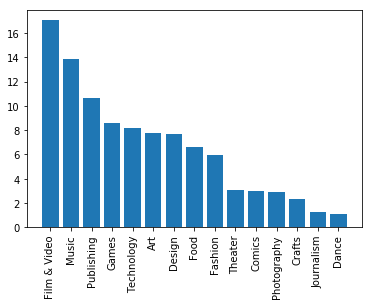

In [103]:
plt.bar(cat_success.index, cat_success['% of projects'])
plt.xlabel('kazkas')
plt.xticks(np.arange(15), cat_success.index, rotation=90)